# Vertical mode decomposition

We want to quantify the evolution of the vertical mode distribution.

This may depend on the choice of stratification that evolves in time.



In [1]:
from glob import glob
import itertools

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd
import crocosi.plot as cplt

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:50341 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


---
## diagnostic flags and runs

In [3]:
# flags
flags = {'surface': True, 'spectra': True, 'depth': True, 'vmodes': True}
overwrite=True

root_path = '/home/c11-data/Test_aponte/fsturb/'

# uniform stratification
#run = 'fsturb_m1_4km_0a1000j/'

# exponential stratification
run = 'fsturb_4km_m1_Nexp_0a1000j'

## Load data

In [4]:
tdir_max=2 # tmp

r = pp.Run(root_path+run, outputs=['surf', 'his'], 
           grid_periodicity=True, tdir_max=tdir_max,
           verbose=1)

r['surf'] = r['surf'].assign_coords(time=r['surf'].time_instant.chunk({'time':None}))
r['his'] = r['his'].assign_coords(time=r['his'].time_counter.chunk({'time':None}))

Analysing directory /home/c11-data/Test_aponte/fsturb/fsturb_4km_m1_Nexp_0a1000j
Found 2 segments
Parameters detected in croco.in :
  time step = 300.0 s
Parameters detected in output.mpi :
Opening datasets: grid / surf / his
Grid size: (L ,M, N) = (258, 722, 50)


## load various stratifications and compare vertical modes

### online (initial) stratification

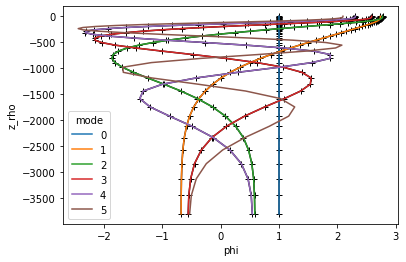

In [5]:
# load vmodes from croco outputfiles
vm_croco, vm = vmd.load_vmodes_from_files(r, tnum=1)

# check consistency visually
for i in range(5):
    plt.plot(vm_croco['phiuv'].isel(mode=i), 
             vm_croco.z_rho.values, marker='+', color='k')
_ = vm['phi'].plot.line(y="z_rho", hue='mode')

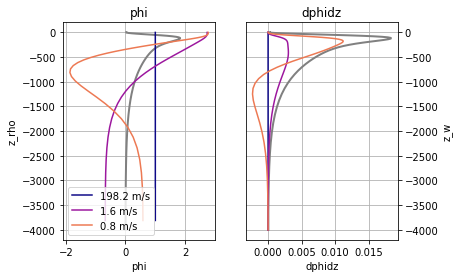

In [6]:
vm.plot()

### final and mean stratification

In [7]:
# final
ds = (r['his']
      .isel(time=-1)
      .mean(dim=['x_rho', 'y_rho'])
      .persist()
     )
rho = ds['T_t_dirac'].rename('rho')
ssh = ds['ssh_t_dirac'].rename('ssh') 

z_r = r.get_z(zeta=ssh, h=ssh*0.+r['depth'])
z_w = r.get_z(zeta=ssh, h=ssh*0.+r['depth'], vgrid='w')

N2 = r.get_N2(rho, z_r)

In [8]:
vm_final = vmd.Vmodes(r['xgrid'], z_r, z_w, N2, vm.nmodes+1,
                      persist=True)

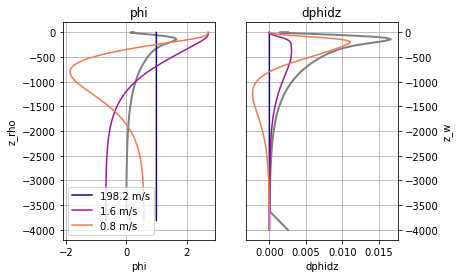

In [9]:
vm_final.plot()

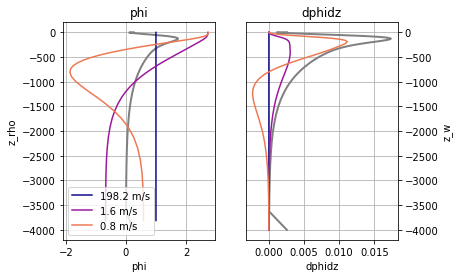

In [10]:
# mean
vm_mean = r.load_vmodes('vmodes', persist=True)
vm_mean.plot()

### cross-project modes

In [11]:
def cross_project_modes(vm0, vm1):
    """ Cross-project modes and ouput diagonals
    """
    ds0 = vm0.ds.rename({'mode':'mode0'})
    cross = vm1.project(ds0).rename({'mode':'mode1'})
    #
    modes = list(set(cross.mode0.values)&set(cross.mode1.values))
    modes = xr.DataArray(modes, dims=['mode'])
    diag = cross.sel(mode0=modes, mode1=modes)
    sdiag = cross.sel(mode0=modes, mode1=modes+1)
    return cross, diag, sdiag

0.9980120964506654


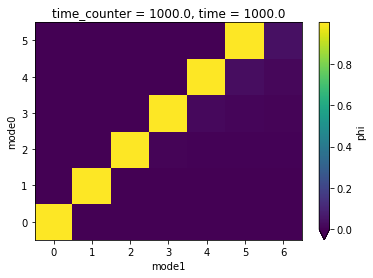

In [12]:
cross, diag, sdiag = cross_project_modes(vm, vm_final)
cross.phi.plot(vmin=0.)
print(cross.phi.where(cross.phi>0.5).min().values)

Text(0.5, 1.0, 'diagonal projections')

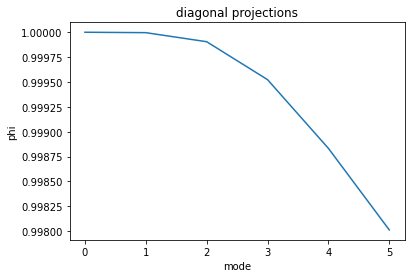

In [13]:
hdl = diag.phi.plot()
hdl[0].axes.set_title('diagonal projections')

Text(0.5, 1.0, 'off-diagonal projections')

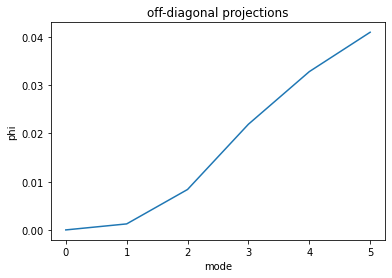

In [14]:
hdl = sdiag.phi.plot()
hdl[0].axes.set_title('off-diagonal projections')

---

## start looking at projections

In [16]:
# load diag_store projection
ds = xr.merge([r.load_diagnostic('vmodes_{}n'.format(v)) for v in ['u', 'v']])

# compute averaged kinetic energies
ds['u2'] = ds['un']**2
ds['v2'] = ds['vn']**2
ds_mean = ds.mean(dim=['x_rho', 'y_rho', 'x_u', 'y_v']).persist()
ds_mean['ke'] = 0.5*(ds_mean.u2+ds_mean.v2)

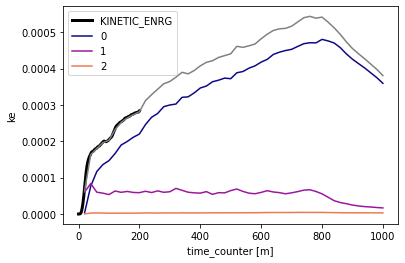

In [27]:
ax = r.stats['KINETIC_ENRG'].plot(lw=3., color='k')

mode_max = 3
colors = cplt.get_cmap_colors(mode_max)

for n, c in zip(range(mode_max),colors):
    ds_mean.sel(mode=n).ke.plot(x='time', color=c, label='{}'.format(n))

ds_mean.ke.sum(dim=['mode']) .plot(x='time', color='0.5')

ax.legend()

In [28]:
r.params_input

{'dt': 300.0, 'theta_s': 5.0, 'theta_b': 0.0, 'Hc': 100.0, 'rho0': 1000.0}

---
### pressure projection does not look right, maybe

In [9]:
# compute pressure on rho grid
rho = ds['T_t_dirac'].rename('rho')
p = r.get_p(rho, z_w, zr=z_r)
p0 = p

# interpolates on mode vertical grid
p = gop.interp2z(vmodes['z_rho'], z_r, p)
p1 = p

# substract time and spatial average
p = p - ds_depth['p'] 

# project, data is already on vmode vertical grid
pn = vmodes.project(p, 'p')
# abs(ds_depth['z_rho'] - vmodes['z_rho']).max().compute() # 0

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 24
  **blockwise_kwargs,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 24
  **blockwise_kwargs,
/home1/datahome/aponte/croco/crocosi/gridop.py:533: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)


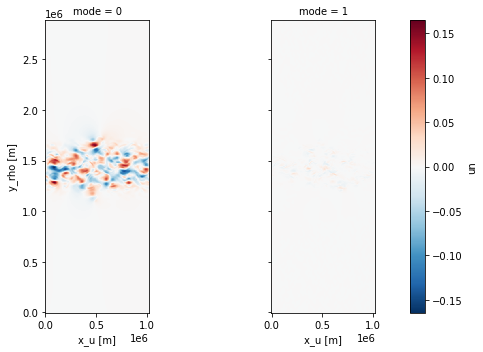

In [16]:
it=4
kwargs_plt = {'col': 'mode', 'figsize': (10,5), 
              'aspect': .5, 'subplot_kws': {'aspect':'equal'}
             }
un.isel(time=it, mode=[0,1]).plot(**kwargs_plt)

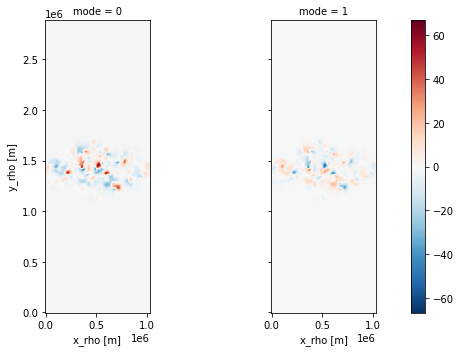

In [17]:
pn.isel(time=it, mode=[0,1]).plot(**kwargs_plt)

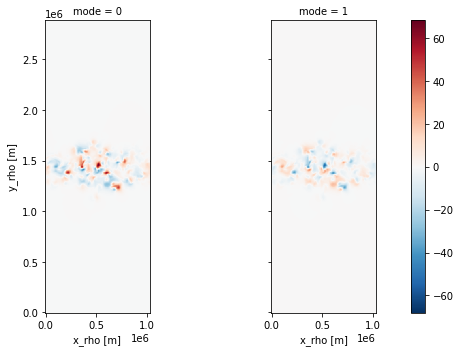

In [18]:
_p = pn.isel(time=it, mode=[0,1])
(_p-_p.mean(['x_rho','y_rho'])).plot(**kwargs_plt)

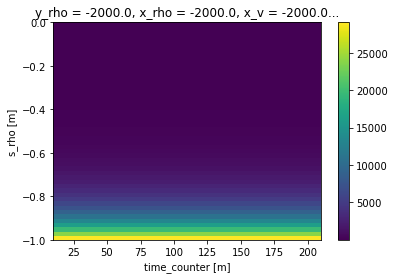

In [19]:
p1.isel(x_rho=0, y_rho=0).plot(x='time')

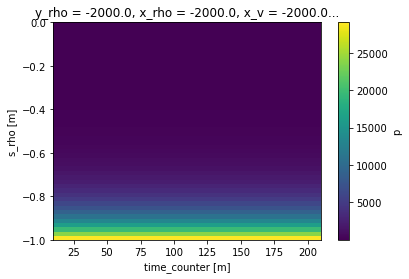

In [20]:
p0.isel(x_rho=0, y_rho=0).plot(x='time')

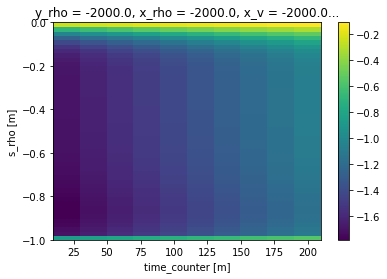

In [21]:
p.isel(x_rho=0, y_rho=0).plot(x='time')

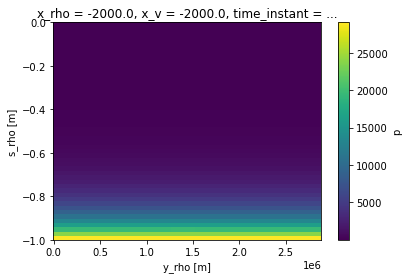

In [22]:
p0.isel(time=it, x_rho=0).plot()

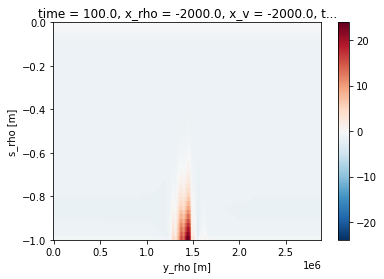

In [26]:
p.isel(time=it, x_rho=0).plot(x='y_rho')

In [24]:
pn.isel(time=it, mode=0).std().compute()

<xarray.DataArray ()>
array(3.69885017)
Coordinates:
    time          float64 100.0
    time_instant  float64 100.0
    mode          int64 0

In [25]:
pn.isel(time=it, mode=1).std().compute()

<xarray.DataArray ()>
array(2.70526879)
Coordinates:
    time          float64 100.0
    time_instant  float64 100.0
    mode          int64 1

---

In [27]:
cluster.close()